<a href="https://colab.research.google.com/github/gptix/DS-Unit-2-Applied-Modeling/blob/master/Jud_Taylor_DS_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍕

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [0]:
train_bak = train.copy()
test_bak = test.copy()

In [0]:
train = train_bak.copy()
test = test_bak.copy()

**'Violations' is leaky, since it is basically a detailing of 'Fail'.**

In [0]:
# train.columns
# Violations is leaky, since it will correlate very highly with pass/fail.
# train.head()
# train.Fail.value_counts()
# change all data in 'City' to uppercase

In [0]:
cols_to_drop = ['Violations'  # leaks, because having a violation is highly correlated with 'Fail'
                , 'Location' # duplicates data in "Latitude" and 'Longitude'
                , 'State'    # invariant
                , 'AKA_Name' # Duplicate of DBA name
                , 'Inspection_ID'  # Seems to be overfitting
                # , 'Inspection_Date' # Probably not useful going forward
                ]

def wrangle(frame):
  """Wrangle data in a frame in a uniform way."""
  frame.columns = [colname.replace(' ','_') for colname in frame.columns]
  frame['City'] = frame['City'].str.upper()
  frame['City'] = frame['City'].replace('CCHICAGO', 'CHICAGO')
  frame['City'] = frame['City'].replace('CHICAGOI', 'CHICAGO') 
  frame['City'] = frame['City'].replace('CHICAGOHICAGO', 'CHICAGO')
  frame['City'] = frame['City'].replace('CHCHICAGO', 'CHICAGO')
  frame['City'] = frame['City'].replace('CHICAGOCHICAGO', 'CHICAGO')
  frame['Risk_int'] = frame['Risk'].map({'Risk 1 (High)': 1, 'Risk 2 (Medium)' : 2, 'Risk 3 (Low)' : 3})
  frame.drop(columns=['Risk'], inplace=True)
  frame.drop(columns=cols_to_drop, inplace=True)
  # replace missing numeric data with means
  frame['Latitude'].fillna((frame['Latitude'].mean()), inplace=True)
  frame['Longitude'].fillna((frame['Longitude'].mean()), inplace=True)
  frame['Risk_int'].fillna((frame['Risk_int'].mean()), inplace=True)
  frame['Zip'].fillna((frame['Zip'].mean()), inplace=True)
  frame['License_#'].fillna("missing_data", inplace=True)
  frame['Facility_Type'].fillna("missing_data", inplace=True)
  frame['City'].fillna("missing_data", inplace=True)
  frame['Inspection_Type'].fillna("missing_data", inplace=True)

  # split date into year, month, date
  frame['Inspection_Date'] = pd.to_datetime(frame['Inspection_Date'], infer_datetime_format=True)
  frame['inspection_year'] = frame['Inspection_Date'].dt.year
  frame['inspection_month'] = frame['Inspection_Date'].dt.month
  frame['inspection_day'] = frame['Inspection_Date'].dt.day
  frame.drop(columns=['Inspection_Date'], inplace=True)


wrangle(train)
wrangle(test)

# test.City.value_counts()

In [308]:
train.columns

Index(['DBA_Name', 'License_#', 'Facility_Type', 'Address', 'City', 'Zip',
       'Inspection_Type', 'Latitude', 'Longitude', 'Fail', 'Risk_int',
       'inspection_year', 'inspection_month', 'inspection_day'],
      dtype='object')

In [0]:
# train['Inspection_Type'].value_counts()

In [0]:
# train.head()

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [311]:
import numpy as np
# import pandas as pd
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size=0.80, test_size=0.20,  random_state=1984)

print(train.shape, val.shape, test.shape)
# printout should be be
# (41532, 13) (10384, 13) (17306, 13)

(41532, 14) (10384, 14) (17306, 14)


In [312]:
# For each set, make X and y
target = 'Fail'

X_train = train.drop(columns=target)
y_train = train[target]

X_val = val.drop(columns=target)
y_val = val[target]

X_test = test.drop(columns=target)
y_test = test[target]

print(X_train.shape, X_val.shape, X_test.shape)
# printout should be be
# (41532, 12) (10384, 12) (17306, 12)

(41532, 13) (10384, 13) (17306, 13)


In [313]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=1984, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7442218798151001


In [314]:
from sklearn.metrics import roc_auc_score
y_pred_proba = pipeline.predict_proba(X_val)[:,-1]
print(roc_auc_score(y_val, y_pred_proba))

0.6725063147622616


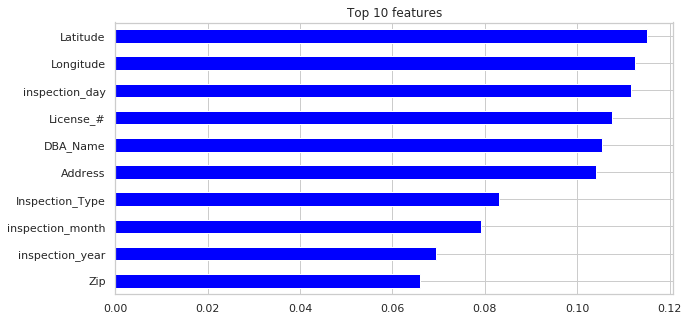

In [315]:
# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

rfc = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rfc.feature_importances_, X_train.columns)

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='blue');

## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

## Permutation Importances


In [316]:
# Permutation Importances
transformers = make_pipeline(ce.OrdinalEncoder(), 
                             SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [317]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=1984
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [318]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

Address            -0.004622
Risk_int           -0.001656
DBA_Name           -0.000559
Latitude           -0.000077
City                0.000000
Longitude           0.000019
License_#           0.000347
Facility_Type       0.001021
inspection_day      0.001445
Zip                 0.001541
inspection_month    0.003814
inspection_year     0.020050
Inspection_Type     0.039002
dtype: float64

In [319]:
import eli5
eli5.show_weights(
    permuter, 
    top=None, # show all
    feature_names=feature_names # Make surew its a list
)

Weight,Feature
0.0390 ± 0.0050,Inspection_Type
0.0201 ± 0.0036,inspection_year
0.0038 ± 0.0013,inspection_month
0.0015 ± 0.0020,Zip
0.0014 ± 0.0030,inspection_day
0.0010 ± 0.0028,Facility_Type
0.0003 ± 0.0012,License_#
0.0000 ± 0.0038,Longitude
0 ± 0.0000,City
-0.0001 ± 0.0049,Latitude


In [320]:
# remove counterproductive features
print('Shape before removing features:', X_train.shape)

# Shape before removing features: (41532, 13)

Shape before removing features: (41532, 13)


In [0]:
min_importance = 0
feature_mask = permuter.feature_importances_ > min_importance
features = X_train.columns[feature_mask]
X_train = X_train[features]

# Note that features has been redefined.

In [322]:
print('Shape after removing features:', X_train.shape)
# Shape after removing features: (41532, 8)

Shape after removing features: (41532, 8)


In [323]:
# Re-fit
X_val = X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.747977657935285


In [324]:
features

Index(['License_#', 'Facility_Type', 'Zip', 'Inspection_Type', 'Longitude',
       'inspection_year', 'inspection_month', 'inspection_day'],
      dtype='object')

## Partial Dependence Plot, 1 feature isolation

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72    # CHANGE THIS FOR FINAL PUBLICATION


from pdpbox.pdp import pdp_isolate, pdp_plot



# Problems below.

In [326]:
feature = 'Facility_Type'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

TypeError: ignored

In [0]:
import category_encoders as ce
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier



In [0]:
# tr = train_bak
# tr.columns
# tst = test_bak
# merged = pd.merge(tr, tst)

# merged.columns
# all = wrangle(merged)

# features
X = all[features]
# y = all[target]

# encoder = ce.OrdinalEncoder()
# X_encoded = encoder.fit_transform(X)

# model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# model.fit(X_encoded, y)